# DataLab Cup 4 : Unlearnable Dataset
`Neural Tangent Generalization Attacks (NTGA)`

# Dataset Download
CAUTION: If you nerver download dataset from Kaggle before, plz follow the tutorial in this page: https://www.endtoend.ai/tutorial/how-to-download-kaggle-datasets-on-ubuntu/

## CIFAR-10

In [6]:
!kaggle competitions download -c datalab-cup4-unlearnable-datasets-cifar-10

100%|███████████████████████████████████████▉| 241M/242M [00:24<00:00, 11.5MB/s]
100%|████████████████████████████████████████| 242M/242M [00:24<00:00, 10.3MB/s]


In [8]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    zf.extractall('./dataset')

file_path = './datalab-cup4-unlearnable-datasets-cifar-10.zip'
zip_list(file_path)

## Imagenet

In [20]:
!kaggle competitions download -c datalab-cup4-unlearnable-datasets-imagenet

100%|█████████████████████████████████████▉| 1.21G/1.21G [01:55<00:00, 10.3MB/s]
100%|██████████████████████████████████████| 1.21G/1.21G [01:55<00:00, 11.2MB/s]


In [ ]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    zf.extractall('./dataset')

file_path = './datalab-cup4-unlearnable-datasets-imagenet.zip'
zip_list(file_path)

# Libraries and Packages

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

In [7]:
!nvidia-smi

Mon Jan 10 17:04:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   45C    P8    14W / 250W |     21MiB / 11176MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(gpus[1], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 1 Logical GPUs


# Hyperparameter

In [19]:
BATCH_SIZE = 64
# MODE = 'cifar10'
MODE = 'imagenet'

# Dataset

In [9]:
x_train = np.load(f'./dataset/x_train_{MODE}_unlearn.npy')
y_train = np.load(f'./dataset/y_train_{MODE}.npy')
x_val = np.load(f'./dataset/x_val_{MODE}.npy')
y_val = np.load(f'./dataset/y_val_{MODE}.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

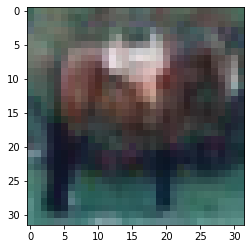

In [14]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][3],cmap='gray')

# Model

In [15]:
model = Sequential([
  keras.Input(shape=(32, 32, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

# Training

In [16]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [17]:
history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=50)

Epoch 1/50
625/625 [==============================] - 5s 6ms/step - loss: 1.4626 - acc: 0.4914 - val_loss: 2.0491 - val_acc: 0.3445
Epoch 2/50
625/625 [==============================] - 5s 8ms/step - loss: 0.5233 - acc: 0.8386 - val_loss: 2.3803 - val_acc: 0.3144
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 0.2957 - acc: 0.9106 - val_loss: 2.6751 - val_acc: 0.2921
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.2076 - acc: 0.9381 - val_loss: 2.8689 - val_acc: 0.2873
Epoch 5/50
625/625 [==============================] - 4s 7ms/step - loss: 0.1559 - acc: 0.9526 - val_loss: 2.8659 - val_acc: 0.3101
Epoch 6/50
625/625 [==============================] - 4s 7ms/step - loss: 0.1203 - acc: 0.9635 - val_loss: 3.2076 - val_acc: 0.2914
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.0958 - acc: 0.9706 - val_loss: 3.9379 - val_acc: 0.2573
Epoch 8/50
625/625 [==============================] - 3s 5ms/step - loss: 0.

# Visualize

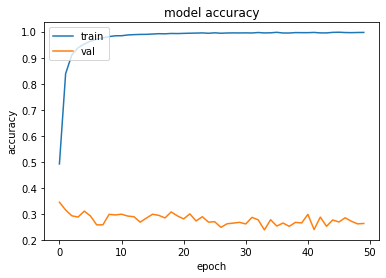

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()